In [1]:
import pandas as pd

df = pd.read_csv('titanic/train.csv')
df.Embarked.replace('Q', '', inplace=True)
df.PassengerId = df.PassengerId.astype('string')

# GET_DF_INFO

In [2]:
def get_df_info(df, *args, **kwargs):
  '''
  Выводит инфу о колонках датафрейма в виде датафрейма
  
  df: 
    исходный датафрейм
  
  # инфа:
  ex1:
    рандомный элемент 
  ex2:
    рандомный элемент отличный от ex1
  vc_max:
    мода и ее частота ее встречаемости
  trash_score:
    max[#nans+#zeros+#empty_str, vcmax.частота*(vcmax.частота>thr)]
  unique, nan, zero, empty_str:
    количество различных/нанов/0/пустых строк

  returns: pd.DataFrame с инфой
  '''
  params = {'thr' : 0.5,}
  params.update(kwargs)

  newdf = pd.DataFrame(index=df.columns)
  newdf['dtype']     = df.apply(lambda col: col.dtype.name)
  newdf['ex1']       = df.apply(lambda col: col.sample(1).iloc[0])
  newdf['ex2']       = df.apply(lambda col: col[col!=newdf['ex1'][col.name]].sample(1).iloc[0])
  newdf['vc_max']    = df.apply(lambda col: (mode:=col.value_counts(sort=False).idxmax(), (col==mode).mean().round(3)), result_type='reduce')
  newdf['unique']    = df.apply(lambda col: col.nunique(dropna=False))
  newdf['nan']       = df.apply(lambda col: x if (x:=col.isna().mean()) else -1)
  newdf['zero']      = df.apply(lambda col: x if (x:=(col==0).mean()  ) else -1)
  newdf['empty_str'] = df.apply(lambda col: x if (x:=(col=='').mean() ) else -1)

  newdf['temp1'] = newdf['vc_max'].apply(lambda x: x[1] if x[1]>params['thr'] else 0)
  newdf['temp2'] = newdf['nan'].replace(-1,0)+newdf['zero'].replace(-1,0)+newdf['empty_str'].replace(-1,0)
  newdf['trash_score'] = newdf[['temp1','temp2']].max(axis=1)
  newdf.drop(columns=['temp1', 'temp2'], inplace=True)

  # round by 3 digits and add special symbols:
  newdf = newdf.round(3)
  newdf['nan']       = newdf['nan'].apply(lambda x: f'n: {x}'  if x!=-1 else -1)
  newdf['zero']      = newdf['zero'].apply(lambda x: f'z: {x}' if x!=-1 else -1)
  newdf['empty_str'] = newdf['empty_str'].apply(lambda x: f'e: {x}' if x!=-1 else -1)
  return newdf

# PlotDensity

In [3]:
import matplotlib as mpl

# настройка размера шрифта легенды
mpl.rcParams['legend.title_fontsize'] = 13
mpl.rcParams['legend.fontsize'] = 13

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

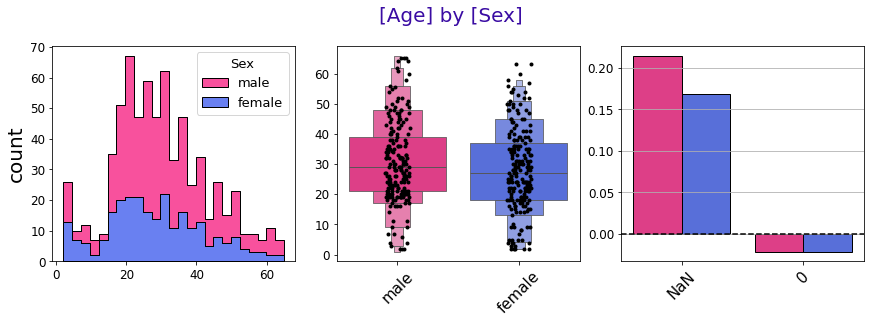

#################################################################################################################


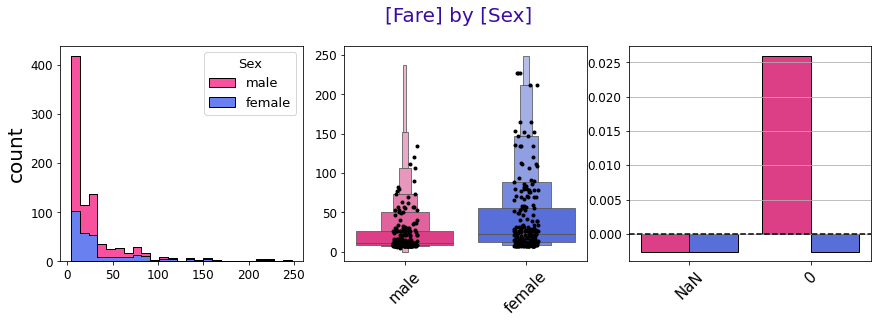

#################################################################################################################


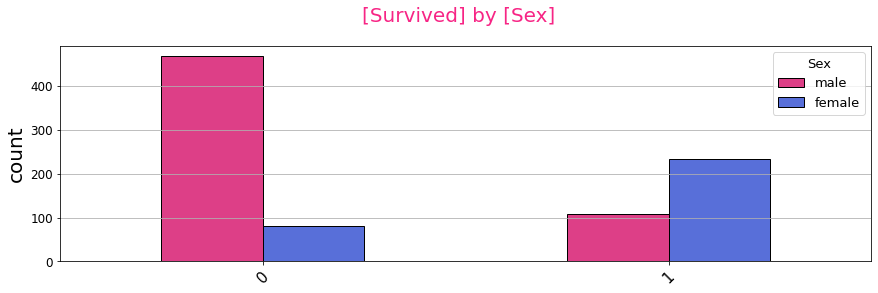

#################################################################################################################


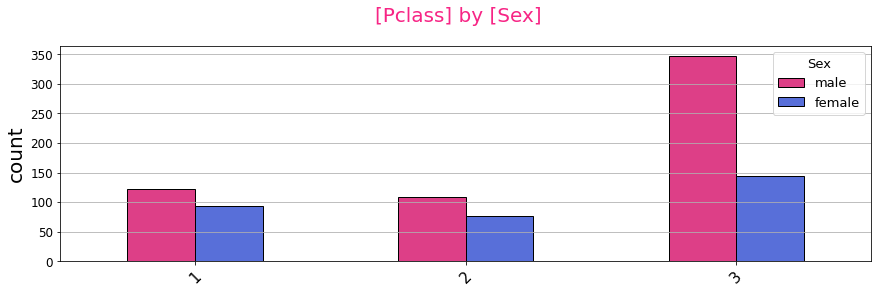

#################################################################################################################


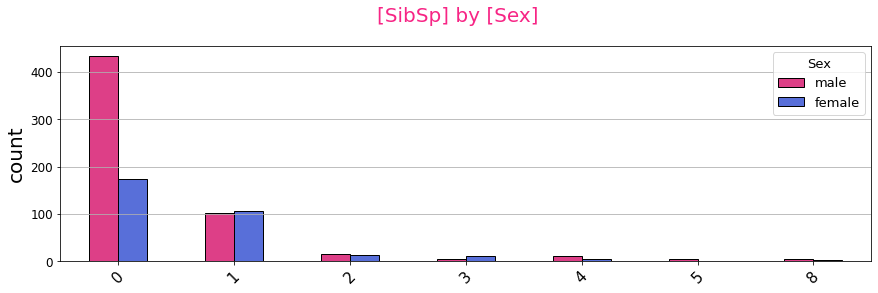

#################################################################################################################


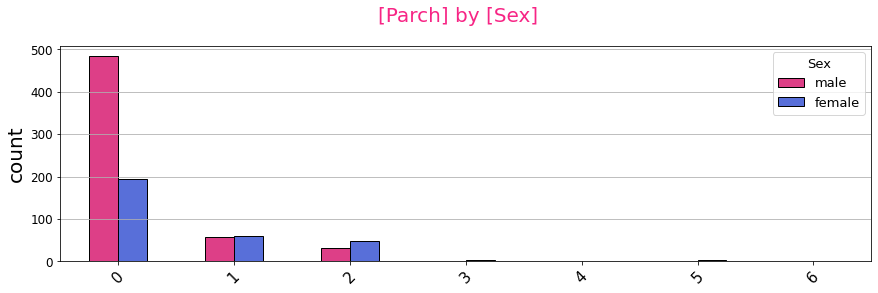

#################################################################################################################


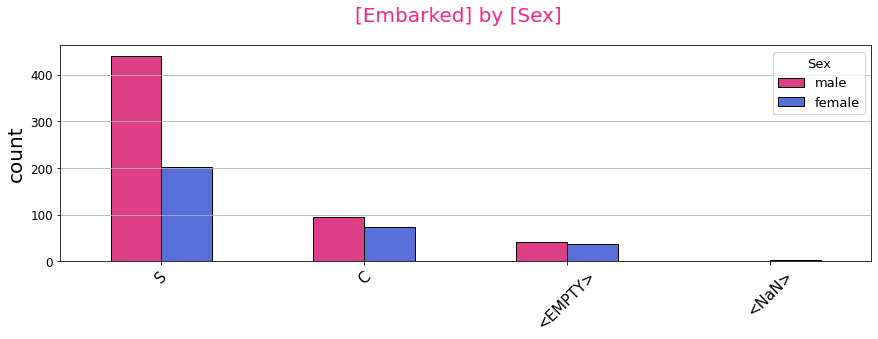

In [6]:
class PlotDensity:
  def __init__(self, df, hue=None, cols=None):
    '''
    This class provides a function for plotting densities depending on pivot column ("hue")

    # Parameters
    df : pd.DataFrame
        initial dataframe

    # Attributes
      df : pd.DataFrame
        initial dataframe
      hue : str
        pivot column
      cols : List(str)
        columns to plot
      cols_numeric : List(str)
        numeric columns to plot
      cols_category : List(str)
        categorical columns to plot

      bins : int
        bins to plot in numerical hist
      max_cat_thr : float
        treshold to distinguish numerical or cat. columns by nunique
      drop_zero : bool
        if True, plots numerical hist and boxenplot without zeroes
      drop_outliers : bool
        if True, plots numerical hist and boxenplot with outliers cutted off
      mypalette : List(str)
        colors

    # See also
    plot_density: str, List(str) -> None
      plots distribution of specified columns relatively to the hue - pivot column.
    '''
    self.df   = df
    self.hue  = hue
    self.cols = cols if cols else [col for col in df.columns if col!=hue]
    self.cols_numeric = []
    self.cols_category = [] 

    self.bins = 25
    self.max_cat_thr = min(len(df)*0.05, 10)
    self.drop_zero     = False
    self.drop_outliers = True
    self.mypalette = ["#F72585", "#4361EE", "#3A0CA3", "#7209B7", "#4CC9F0"]

    self._divideCols()

  def _divideCols(self): pass
  def _fltrZero(self, df, col): pass
  def _fltrOutliers(self, df, col, lq, rq): pass
  def _dfTransform(self, T, col): pass
    
  def plot_density(self, hue=None, cols=None):
    '''
    Рисует распределения колонок cols

    cols: отрисовываемые колонки. Если None, то рисуем df.columns (кроме hue)
    hue:  опорная колонка относительно которой идет сравнение на рисунках
    побочные атрибуты указаны в классе
    '''
    self.hue  = hue  if hue else self.hue
    self.cols = cols if (self._divideCols() and cols) else self.cols
    hue_order = self.df[self.hue].unique()
    palette   = self.mypalette[:len(hue_order)] if len(hue_order)<=5 else sns.color_palette("husl", len(hue_order))

    # numerical first
    for col in self.cols_numeric:
      fig, ax = plt.subplot_mosaic('abc', figsize=(12, 4))
      fig.suptitle(f"[{col}] by [{self.hue}]", fontsize=20, color=self.mypalette[2])
      fig.tight_layout()

      # df_Z and df_O are preprocessed df
      df_Z = self._dfTransform('Z', col)
      df_O = self._dfTransform('O', col)
      if not is_numeric_dtype(df[self.hue]):
        df_Z = df_Z.fillna({self.hue:'<NaN>'}).replace({self.hue:('', '<EMPTY>')}).copy()
        df_Z = df_O.fillna({self.hue:'<NaN>'}).replace({self.hue:('', '<EMPTY>')}).copy()

      # histogram
      sns.histplot(data=df_O, x=col, hue=self.hue, hue_order=hue_order, ax=ax['a'],
                   bins=self.bins, multiple='stack', element='step', stat='count', alpha=0.8, palette=palette)
      
      # boxenplot & stripplot
      sns.boxenplot(data=self.df, y=col, hue=self.hue, x=self.hue, hue_order=hue_order,
                    ax=ax['b'], showfliers=False, legend=False, palette=palette)
      sns.stripplot(data=df_O.groupby(self.hue).apply(lambda x: x.sample(n=200) if x.shape[0]>=200 else x), y=col, x=self.hue,
                    hue_order=hue_order, ax=ax['b'], color='black', size=4, legend=False)
      
      # barplot with nan and 0 counting
      df_n = self.df[col].isna().groupby(self.df[self.hue]).mean().rename('count').reset_index().assign(what='NaN')
      df_z = (self.df[col]==0).groupby(  self.df[self.hue]).mean().rename('count').reset_index().assign(what='0')
      df_spec = pd.concat([df_n, df_z]).reset_index(drop=True)
      df_spec['count'] = df_spec['count'].replace(0, -.1*df_spec['count'].max())
      sns.barplot(data=df_spec, x='what', y='count', hue=self.hue, hue_order=hue_order,\
                  ax=ax['c'], edgecolor='black', legend=False, palette=palette)
      
      # better layout etc
      for i in ax: 
        ax[i].set_ylabel(''), ax[i].tick_params('y', labelsize=12)
        ax[i].set_xlabel(''), ax[i].tick_params('x', rotation=45, labelsize=15)
      ax['a'].set_ylabel('count', fontsize=20)
      ax['a'].tick_params('x', rotation=0, labelsize=12)
      ax['c'].axhline(0, color='black', ls='--')
      ax['c'].grid(True, axis='y')

      plt.show()
      print('#'*113)

    ################################################################################
    # categorial columns
    for col in self.cols_category:
      fig, ax = plt.subplots(figsize=(12, 4))
      fig.suptitle(f"[{col}] by [{self.hue}]", fontsize=20, color=self.mypalette[0])
      fig.tight_layout()

      # countplot using preprocessed data
      sns.countplot(data=self._dfTransform('S'), x=col, hue=self.hue, hue_order=hue_order,\
                    ax=ax, stat='count', edgecolor='black', width=0.5, palette=palette)

      # better layout etc
      ax.tick_params('x', rotation=45, labelsize=15)
      ax.tick_params('y', labelsize=12)
      ax.set_ylabel('count', fontsize=20)
      ax.set_xlabel('')
      ax.grid(True, axis='y')
      
      plt.show()
      print('#'*113 if col!=self.cols_category[-1] else '')

  ################################################################################
  ################################################################################
  def _divideCols(self):
    '''
    divides columns into numerical ones and categorical ones
    using is_numeric_dtype and max_cat_thr
    '''
    self.cols_numeric, self.cols_category = [], []
    for col in [i for i in self.cols if i!=self.hue]:
      if (nonique:=self.df[col].nunique())>=self.max_cat_thr and is_numeric_dtype(self.df[col]):
        self.cols_numeric.append(col)
      elif nonique<self.max_cat_thr:
        self.cols_category.append(col)
    return True

  def _fltrZero(self, df, col):
    '''
    returns df with rows where col has no zeroes if drop_zero == True
    '''
    return df[self.df[col]!=0] if self.drop_zero else df
  
  def _fltrOutliers(self, df, col, lq=0.01, rq=0.99): 
    '''
    returns df with rows where col less than lq quantile and bigger than rq if drop_outliers == True
    '''
    if self.drop_outliers: 
      return df[(df[col].quantile(lq) < df[col]) &\
                (df[col].quantile(rq) > df[col])]
    return df
  
  def _dfTransform(self, T, col=None):
    '''
    applies fltrZero/fltrOutliers/fltrString depending on T
    '''
    match T:
      case 'S':
        return self.df.fillna('<NaN>').replace('', '<EMPTY>')
      case 'Z':
        return self._fltrZero(self.df, col)
      case 'O':
        return self._fltrZero(self._fltrOutliers(self.df, col), col)
      
# simple usage:
PlotDensity(df).plot_density(hue='Sex')

***Вопрос:*** Как вы думаете, какие проблемы с этой рисовалкой могут возникнуть при применении ее на других датасетах?

0. выбросы: на самом деле не проблема, тк в этом коде я порезал данные под 0.01, 0.99 квантили, но если это не делать, то все numerical графики сломаются
1. дисбаланс классов: (даже при hue=Parch это видно) если какого-то категориального значения очень много (доля), то графики не будут информативными (кроме наверное боксенплота для numeric columns). 
2. разный масштаб в numeric колонках при различных значениях hue - это может убить boxenplot (видно для hue=Parch)
3. формально деление на numeric и котегориальные колонки не очень хорошее: нпример, если это фича - почтовые индексы, то алгоритм его воспримет как numeric, хотя он точно категориальный.

- дисбаланс лечится тем, что можно указать отдельные значения hue для анализа, а не все
- масштаб лечится нормировкой, хотя информативность может сильно убавиться
- для лучшей классификации можно смотреть не только на nunique, но и на сами данные: есть ли у них лидирующий ноль, одинаковая ли строковая длина значений, нормально ли они распределены и тд